**We will explore two different approaches for predicting movie ratings.**
- In the first approach, we will focus on using numerical and categorical features from the data set.

- In the second approach, we will analyze the sentiment of movie reviews to predict the movie ratings.

In both approaches we will compare our models' predictions to actual data to evaluate their performance. 

# First Approach
- using only numerical and categorical features from the data set.

In [194]:
# Import all dependencies

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [195]:
# Download data
df = pd.read_csv('data/rotten_tomatoes_movies.csv')
df.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


**Some initial data understanding**

In [196]:
df.shape

(17712, 22)

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              17712 non-null  object 
 1   movie_title                       17712 non-null  object 
 2   movie_info                        17391 non-null  object 
 3   critics_consensus                 9134 non-null   object 
 4   content_rating                    17712 non-null  object 
 5   genres                            17693 non-null  object 
 6   directors                         17518 non-null  object 
 7   authors                           16170 non-null  object 
 8   actors                            17360 non-null  object 
 9   original_release_date             16546 non-null  object 
 10  streaming_release_date            17328 non-null  object 
 11  runtime                           17398 non-null  float64
 12  prod

In [198]:
df.isna().sum()

rotten_tomatoes_link                   0
movie_title                            0
movie_info                           321
critics_consensus                   8578
content_rating                         0
genres                                19
directors                            194
authors                             1542
actors                               352
original_release_date               1166
streaming_release_date               384
runtime                              314
production_company                   499
tomatometer_status                    44
tomatometer_rating                    44
tomatometer_count                     44
audience_status                      448
audience_rating                      296
audience_count                       297
tomatometer_top_critics_count          0
tomatometer_fresh_critics_count        0
tomatometer_rotten_critics_count       0
dtype: int64

**Converting categorical columns into numbers**
- 'audience_status', 'content_rating' and 'tomatometer_status'

In [199]:
# Make a copy of original data frame before you start manipulating it
df_movie = df.copy()

[Text(0, 0, '9390'), Text(0, 0, '7874')]

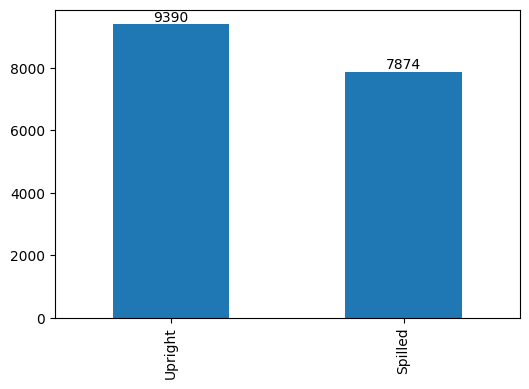

In [200]:
ax = df_movie.audience_status.value_counts().plot(kind='bar', figsize=(6, 4))
ax.bar_label(ax.containers[0])

In [201]:
df_movie = df_movie.dropna(subset=['audience_status', 'tomatometer_status'])

In [202]:
# Using Ordinal encoder on audience_status and tomatometer_status since there is a order in the categoriacal fatures

oe = OrdinalEncoder(categories=[['Spilled', 'Upright']])
df_movie['audience_status'] = oe.fit_transform(df_movie[['audience_status']])

# # Display the learned categories
display(oe.categories_)


[array(['Spilled', 'Upright'], dtype=object)]

In [203]:
oe = OrdinalEncoder(categories=[['Rotten', 'Fresh', 'Certified-Fresh']])
df_movie['tomatometer_status'] = oe.fit_transform(df_movie[['tomatometer_status']])

[Text(0, 0, '6283'),
 Text(0, 0, '5194'),
 Text(0, 0, '2928'),
 Text(0, 0, '2137'),
 Text(0, 0, '675'),
 Text(0, 0, '38')]

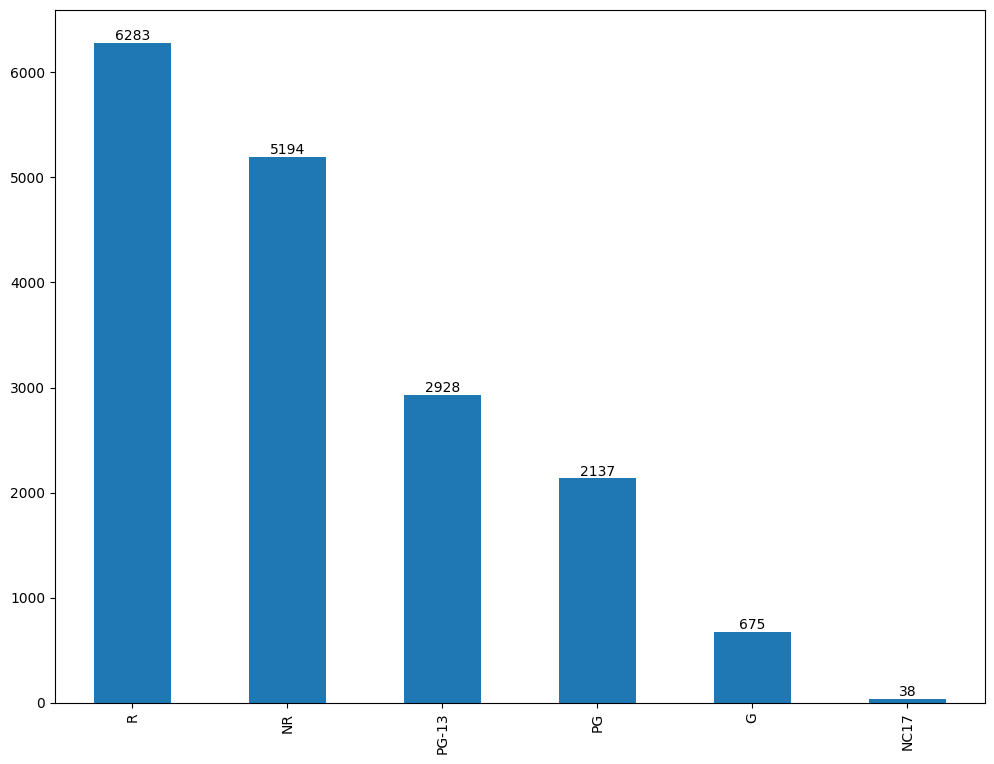

In [204]:
ax = df_movie.content_rating.value_counts().plot(kind='bar', figsize = (12,9))
ax.bar_label(ax.containers[0])

In [205]:
# Using one hot encoding on content_rating as their is no order in the categorical variables.
df_movie = pd.get_dummies(df_movie, columns=['content_rating'])

In [206]:
df_movie.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,genres,directors,authors,actors,original_release_date,streaming_release_date,...,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,content_rating_G,content_rating_NC17,content_rating_NR,content_rating_PG,content_rating_PG-13,content_rating_R
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2015-11-25,...,254421.0,43,73,76,0,0,0,1,0,0
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2012-09-04,...,11574.0,44,123,19,0,0,0,0,0,1
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,2014-07-24,...,14684.0,2,16,8,0,0,0,0,0,1
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2017-01-13,...,105386.0,6,54,0,0,0,1,0,0,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...","Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2016-06-10,...,68918.0,5,24,3,1,0,0,0,0,0


**We will use only few numerical columns for this exercise as not all columns have relevance to the target variable**

In [207]:
numerical_col = ['runtime', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_rating', 'audience_count',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'tomatometer_rotten_critics_count', 'audience_status',
       'content_rating_G', 'content_rating_NC17', 'content_rating_NR',
       'content_rating_PG', 'content_rating_PG-13', 'content_rating_R']

In [208]:
num_df = df_movie[numerical_col]
num_df.head()

,runtime,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,audience_status,content_rating_G,content_rating_NC17,content_rating_NR,content_rating_PG,content_rating_PG-13,content_rating_R
0,119.0,0.0,49.0,149.0,53.0,254421.0,43,73,76,0.0,0,0,0,1,0,0
1,90.0,2.0,87.0,142.0,64.0,11574.0,44,123,19,1.0,0,0,0,0,0,1
2,122.0,1.0,67.0,24.0,53.0,14684.0,2,16,8,0.0,0,0,0,0,0,1
3,95.0,2.0,100.0,54.0,97.0,105386.0,6,54,0,1.0,0,0,1,0,0,0
4,127.0,1.0,89.0,27.0,74.0,68918.0,5,24,3,1.0,1,0,0,0,0,0


In [209]:
# Drop any missing values from the dataframe
num_df = num_df.dropna()
num_df.isna().sum()

runtime                             0
tomatometer_status                  0
tomatometer_rating                  0
tomatometer_count                   0
audience_rating                     0
audience_count                      0
tomatometer_top_critics_count       0
tomatometer_fresh_critics_count     0
tomatometer_rotten_critics_count    0
audience_status                     0
content_rating_G                    0
content_rating_NC17                 0
content_rating_NR                   0
content_rating_PG                   0
content_rating_PG-13                0
content_rating_R                    0
dtype: int64

In [210]:
# Final shape of our datframe that we will work on
num_df.shape

(17017, 16)

[Text(0, 0, '7375'), Text(0, 0, '6475'), Text(0, 0, '3167')]

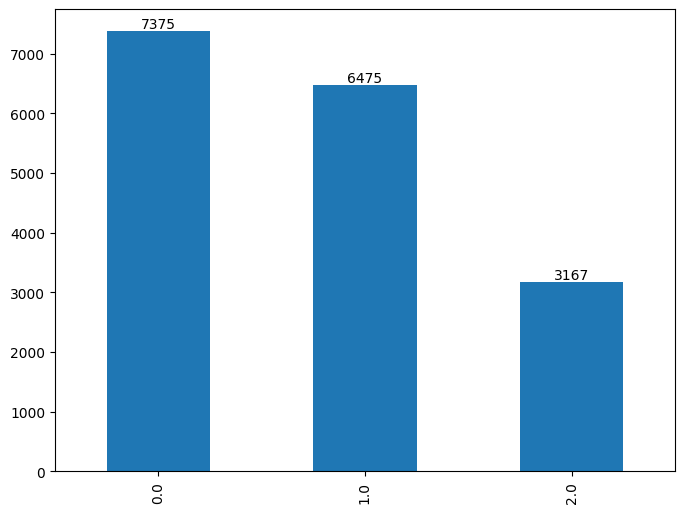

In [211]:
# Lets check the distribution of the classes in our target variable

ax = num_df.tomatometer_status.value_counts().plot(kind='bar', figsize=(8,6))
ax.bar_label(ax.containers[0])

In [212]:
X_train, X_test, y_train, y_test = train_test_split(num_df.drop('tomatometer_status', axis=1),\
                                                    num_df.tomatometer_status, test_size= 0.2,\
                                                   random_state = 5)
print(f'Length of train set is {len(X_train)} and length of test set is {len(X_test)}')

Length of train set is 13613 and length of test set is 3404
